<a href="https://colab.research.google.com/github/NemesisCrociata/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales
Nemesis Crociata
## Project Overview
- An overview of products and outlets for our client, a major grocer retailer, that play crucial roles in increasing sales.

## Load and Inspect Data

In [ ]:
# Relevant packages are imported.

import pandas as pd
import numpy as np
import missingno as msno
pd.set_option('display.max_columns',100)

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn import set_config
set_config(transform_output='pandas')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# The data is stored as the variable 'file'.

file = "/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"

# The csv file is read and stored as a Pandas DataFrame.

df = pd.read_csv(file)

In [ ]:
# First 5 columns

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
# Last 5 columns

df.tail()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976
8522,DRG01,14.800,Low Fat,0.044878,Soft Drinks,75.4670,OUT046,1997,Small,Tier 1,Supermarket Type1,765.6700


In [ ]:
# Summary of the DataFrame, including columns and rows count, non-null counts, and data types of each column.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Data Dictionary

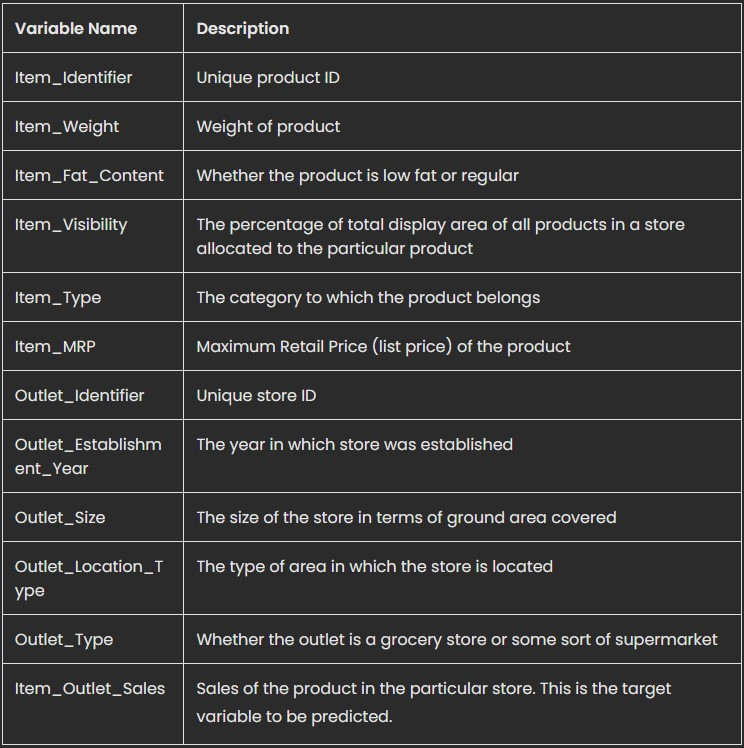

## Setting the style

In [ ]:
# Matplotlib and Seaborn are imported to easily create visualizations.

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [ ]:
# We use Seaborn's .set_context() function to adjust all subsequent
# visualizations for legibility within the Github repository.
# 'notebook' is used for the Google Colaboratory format.

sns.set_context('notebook', font_scale=1.5)

# The attribute .style is used with the method .use()
# to set the style of all graphs created henceforth.

plt.style.use(['fivethirtyeight'])

# scatter_kws stores a dictionary which sets 'edgecolor' to white.
# This will be used to clearly distinguish the many points on a scatterplot.
scatter_kws = dict(edgecolor='white')

In [ ]:
# A function is created to display a barplot of univariate object-type data.
# Credit to the Coding Dojo.

# The function is created with parameters for the dataset, x-axis value(s),
# whether null values should be filled, the placeholder,
# the size of the graph, and order of values.

def viz_categorical(df, x, fillna=True, placeholder='MISSING',
                    figsize=(6,6), order=None):
  # A temporary DataFrame is created to fill missing values.
  viz_df = df.copy()

  # The total null values for the feature is stored.
  null_count = viz_df[x].isna().sum()
  # The percent of total null values for the feature is stored.
  null_percent = null_count / len(viz_df) * 100
  # The function to fill null values is created.
  # If fillna == False, this code will not be executed and nulls will remain.
  if fillna == True:
    viz_df[x] = viz_df[x].fillna(placeholder)

  # The figure and axes are created.
  # Figsize parameter is set.
  fig, ax = plt.subplots(figsize=figsize)
  # Seaborn is used to create a barplot that counts values.
  # Data is automatically set to the temporary DataFrame.
  # Parameters for x-axis, axes, and order are set.
  sns.countplot(data=viz_df, x=x, ax=ax, order=order)
  # X-axis tick labels are adjusted to preference.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Title is set to display feature. Adjusted to preference.
  ax.set_title(f"Column: {x}", fontweight='bold')

  # A tight layout of information on the axes is shown.
  fig.tight_layout()
  # The graph is shown.
  plt.show()

  # Information on null values is printed.
  print(f"- NaN's Found: {null_count} ({round(null_percent, 2)}%)")
  # Statement about treatment of nulls is printed if nulls exist.
  if null_count >0:
    print(f"Null values will be filled with the placeholder, 'MISSING'.")

  # No. of unique values in feature is stored.
  nunique = viz_df[x].nunique()
  # Statement about high or low cardinality is printed depending on count.
  if nunique >10:
    print(f"- High cardinality; {nunique} unique values.")
  else:
    print(f"- Low cardinality; {nunique} unique values.")

  # Value counts of feature are shown. Nulls are included.
  value_counts = viz_df[x].value_counts(dropna=False)
  # 1st item in value counts list is stored.
  most_common_value = value_counts.index[0]
  # Frequency of 1st item in value counts list is stored.
  frequency = value_counts.values[0]
  # Percent of most common value is stored.
  percent_most_common = frequency / len(viz_df) * 100

  # Statement about most common value is printed.
  print(f"- Most common value: '{most_common_value}' occurs {frequency} times ({round(percent_most_common, 2)}%)")
  # Statement about constant/quasi-constanct quality is printed if
  # most common feature makes up at least 98% of the total.
  if percent_most_common > 98:
        print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  # Else statement is printed stating feature is not constant.
  else:
    print("- Not constant or quasi-constant.")

In [ ]:
# A function is created to display both a histogram and a boxplot
# of univariate numerical-type data.
# Credit to the Coding Dojo.

def viz_numerical(df, x, figsize=(6,6)):
  viz_df = df.copy()

  # A variable is created to store height ratios for the histogram and boxplot.
  # The boxplot does not need to be the same height as the histogram,
  # therefore is smaller to conserve space.
  gridspec = {'height_ratios':[0.7, 0.3]}

  # Multiple axes are created with two rows (nrows).
  # Sharex=True means both graphs will share x-axis labels.
  # gridspec_kw is set to stored variable. Only height ratios will be adjusted.
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)

  # A histogram is created on the first axes.
  sns.histplot(data=df, x=x, ax=axes[0])
  # A boxplot is created on the second axes.
  sns.boxplot(data=df, x=x, ax=axes[1])
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  fig.tight_layout()
  plt.show()

  # Unlike categorical columns, numerical columns have only one type of feature.
  # Therefore, a statement is printed displaying the type of feature.
  print('Type of feature: Numerical')

  null_count = df[x].isna().sum()
  null_percent = null_count / len(df) * 100
  print(f"- NaN's Found: {null_count} ({round(null_percent, 2)}%)")

  if null_count >0:
    print(f"Null values will be filled with the mean of the column.")

  # The function returns the graphs created.
  return fig, axes

In [ ]:
# A function is created to display a barplot and stripplot
# of object-type data against the target feature.
# Credit to the Coding Dojo

# A y parameter is created for the target.
def viz_categorical_vs_target(df, x, y,figsize=(6,6),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  viz_df = df.copy()

  if fillna == True:
    viz_df[x] = viz_df[x].fillna(placeholder)
  else:
    viz_df = viz_df.dropna(subset=[x])

  fig, ax = plt.subplots(figsize=figsize)

  # A barplot is created first.
  # Adjustments are made to aesthetic preference.
  sns.barplot(data=viz_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # A stripplot is created afterwards.
  # A legend is not created since the colors are in correspondence
  # with the barplot, which is labeled on the x-axis.
  # Adjustments are made to aesthetic preference.
  sns.stripplot(data=viz_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)

  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()

  return fig, ax

In [ ]:
# A function is created to display a scatterplot and a line of correlation
# of numerical-type data against the target feature.
# Credit to the Coding Dojo

# **kwargs is added so additional parameters can be passed that are found
# in the sns.regplot function.
def viz_numeric_vs_target(df, x, y, figsize=(6,6), **kwargs):
  # The correlation is stored.
  correlation = df[[x,y]].corr().round(2)
  # The correlation value is stored.
  r = correlation.loc[x,y]

  fig, ax = plt.subplots(figsize=figsize)
  #The scatter dots are adjusted to aesthetic preference.
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}

  # A regression plot is created. Parameters are set.
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)
  # The correlation value is included in the title.
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  plt.show()
  return fig, ax

## Clean Data

In [ ]:
# The .shape attribute returns the number of rows and columns in the DataFrame.

df.shape

print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

There are 8523 rows and 12 columns.


- To start, some columns are renamed for clarity.

In [ ]:
# A dictionary is created to rename certain columns.
# Old labels are keys and new labels are the corresponding values.

rename_dict = {'Item_Identifier': 'Item_ID',
               'Item_MRP': 'Maximum_Retail_Price',
               'Outlet_Location_Type': 'Location_Type'}

# The .rename() method passes the dictionary through. Axis=1 sets this to
# columns rather than rows.

df = df.rename(rename_dict, axis=1)
df.head()

,Item_ID,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Maximum_Retail_Price,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Checking for duplicated rows

In [ ]:
# The .sum() method is used on the .duplicated() method to get the total amount
# of duplicated rows in the DataFrame.

df.duplicated().sum()

0

**Since there are no duplicated rows in the data set, no rows are removed.**

### Checking for unnecessary columns

- Unique values are shown for each column.

In [ ]:
# Unique values are called using the .nunique() method.
# This is stored in a new variable named unique_vals.

unique_vals = df.nunique()
unique_vals

Item_ID                      1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Maximum_Retail_Price         5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Location_Type                   3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

- The percentage of unique values are calculated.

In [ ]:
# The number of unique values is divided by the total rows in the DataFrame.
# The result is multiplied by 100 to create percentages.

unique_vals / len(df) * 100

Item_ID                      18.291681
Item_Weight                   4.869178
Item_Fat_Content              0.058665
Item_Visibility              92.455708
Item_Type                     0.187727
Maximum_Retail_Price         69.670304
Outlet_Identifier             0.117330
Outlet_Establishment_Year     0.105597
Outlet_Size                   0.035199
Location_Type                 0.035199
Outlet_Type                   0.046932
Item_Outlet_Sales            40.983222
dtype: float64

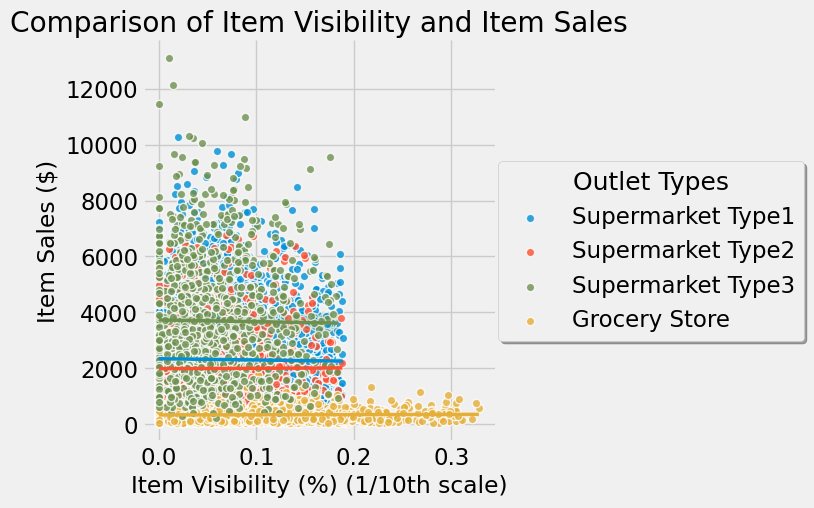

In [ ]:
# Some features seem irrelevant to the target feature.
# They will be plotted to visualize their correlation to Item Sales.

# Seaborn is used to create a regression plot.

ax = sns.lmplot(data=df, x='Item_Visibility', y='Item_Outlet_Sales',
                scatter_kws=scatter_kws, hue='Outlet_Type',
                line_kws={'lw':2.5}, legend=False)

ax.set(xlabel= 'Item Visibility (%) (1/10th scale)', ylabel= 'Item Sales ($)',
       title='Comparison of Item Visibility and Item Sales')

# A legend is set to show the labels in order.

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,3,2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           loc=(1.01, 0.25), shadow=True, title='Outlet Types')

plt.show();

In [ ]:
# Due to extremely high cardinality for 'Item_ID' and no correlation between
# 'Item_Visibility' and 'Item_Outlet_Sales', both features will be dropped.

df.drop(columns=['Item_ID', 'Item_Visibility'], inplace=True)
df.head()

,Item_Weight,Item_Fat_Content,Item_Type,Maximum_Retail_Price,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


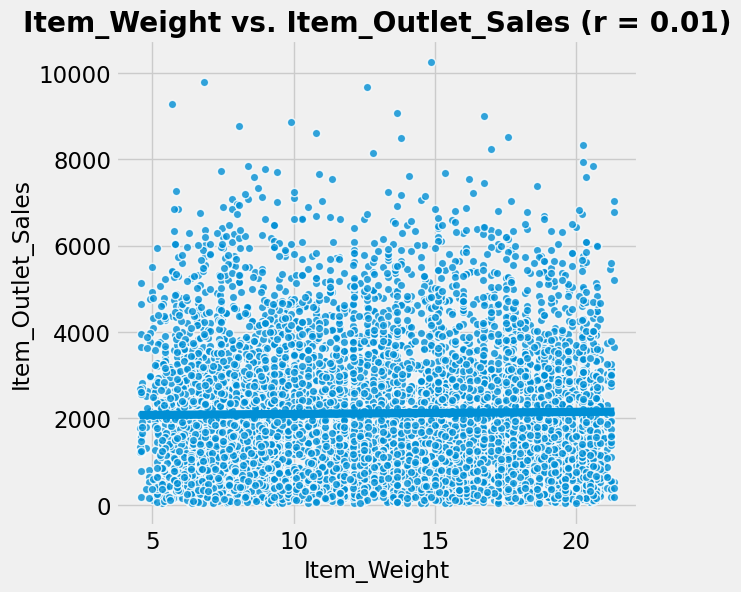

In [ ]:
# A scatterplot is created to compare Item Weight and Item Sales.

viz_numeric_vs_target(df, x='Item_Weight', y='Item_Outlet_Sales');

In [ ]:
# There is no visible correlation between 'Item_Weight' and 'Item_Outlet_Sales'.
# 'Item_Weight' will be dropped from the dataset.

df.drop(columns='Item_Weight', inplace=True)
df.head()

,Item_Fat_Content,Item_Type,Maximum_Retail_Price,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Location_Type,Outlet_Type,Item_Outlet_Sales
0,Low Fat,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,Regular,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,Low Fat,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,Regular,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,Low Fat,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Checking for column data types

In [ ]:
# The attribute .dtypes shows only the column names and their data types.

df.dtypes

Item_Fat_Content              object
Item_Type                     object
Maximum_Retail_Price         float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Location_Type                 object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

*Columns that require further inspection are 'Location_Type' and 'Outlet_Type'.*

- <u>Location Type</u>, renamed 'Location_Type', is defined as "[t]he type of area in which the store is located".
  - Although the values could be reduced to their numerical value, this isn't appropriate for the data.

- <u>Outlet Type</u> is defined as "[w]hether the outlet is a grocery store or some sort of supermarket".
  - Again, although the values can be reduced to a numerical value, this isn't appropriate for the data.


**No column data types need to be adjusted.**
  - This section may be revisited after data exploration.

### Checking for impossible values

In [ ]:
# .describe() is used to pull a summary of numerical columns.

df.describe()

,Maximum_Retail_Price,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000
mean,140.992782,1997.831867,2181.288914
std,62.275067,8.371760,1706.499616
min,31.290000,1985.000000,33.290000
25%,93.826500,1987.000000,834.247400
50%,143.012800,1999.000000,1794.331000
75%,185.643700,2004.000000,3101.296400
max,266.888400,2009.000000,13086.964800


**There are no impossible values in the dataset.**

### Checking for consistent values

In [ ]:
# The value counts from each column are pulled using a for loop.
# Each loop will get the value counts of a single column.

for col in df.columns:
  print(f'Value Counts for {col}:')
  print(df[col].value_counts ())
  print('\n')

Value Counts for Item_Fat_Content:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Maximum_Retail_Price:
172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           ..
97.3384     1
83.1934     1
96.6752     1
152.6682    1
75.4670     1
Name: Maximum_Retail_Price, Length: 5938, dtype: int64


Value Counts for Outlet_Identifier:
OUT027    935
OUT013

- We can see there are values in 'Item_Fat_Content' that can be renamed and merged.

In [ ]:
# Values in 'Item_Fat_Content' are renamed using the .replace() method with
# a short dictionary inserted.
# Value counts are called again to see the new results.

df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                         'reg': 'Regular',
                                                         'low fat': 'Low Fat'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
# 'Item_Type' has high cardinality.
# To better fit the model, some values are grouped together.

item_type_labels = {'Seafood': 'Meat',

                    'Soft Drinks': 'Drinks',
                    'Hard Drinks': 'Drinks',

                    'Breads': 'Misc. Food',
                    'Canned': 'Misc. Food',
                    'Baking Goods': 'Misc. Food',
                    'Starchy Foods': 'Misc. Food',
                    'Breakfast': 'Misc. Food'}

df['Item_Type'] = df['Item_Type'].replace(item_type_labels)
df['Item_Type'].value_counts()

Misc. Food               1806
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Drinks                    659
Health and Hygiene        520
Meat                      489
Others                    169
Name: Item_Type, dtype: int64

### Checking for null values

In [ ]:
# A null value count is pulled from the data set using the .isna() method.
# The .sum() method is used to call the total null value counts.

df.isna().sum()

Item_Fat_Content                0
Item_Type                       0
Maximum_Retail_Price            0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Location_Type                   0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

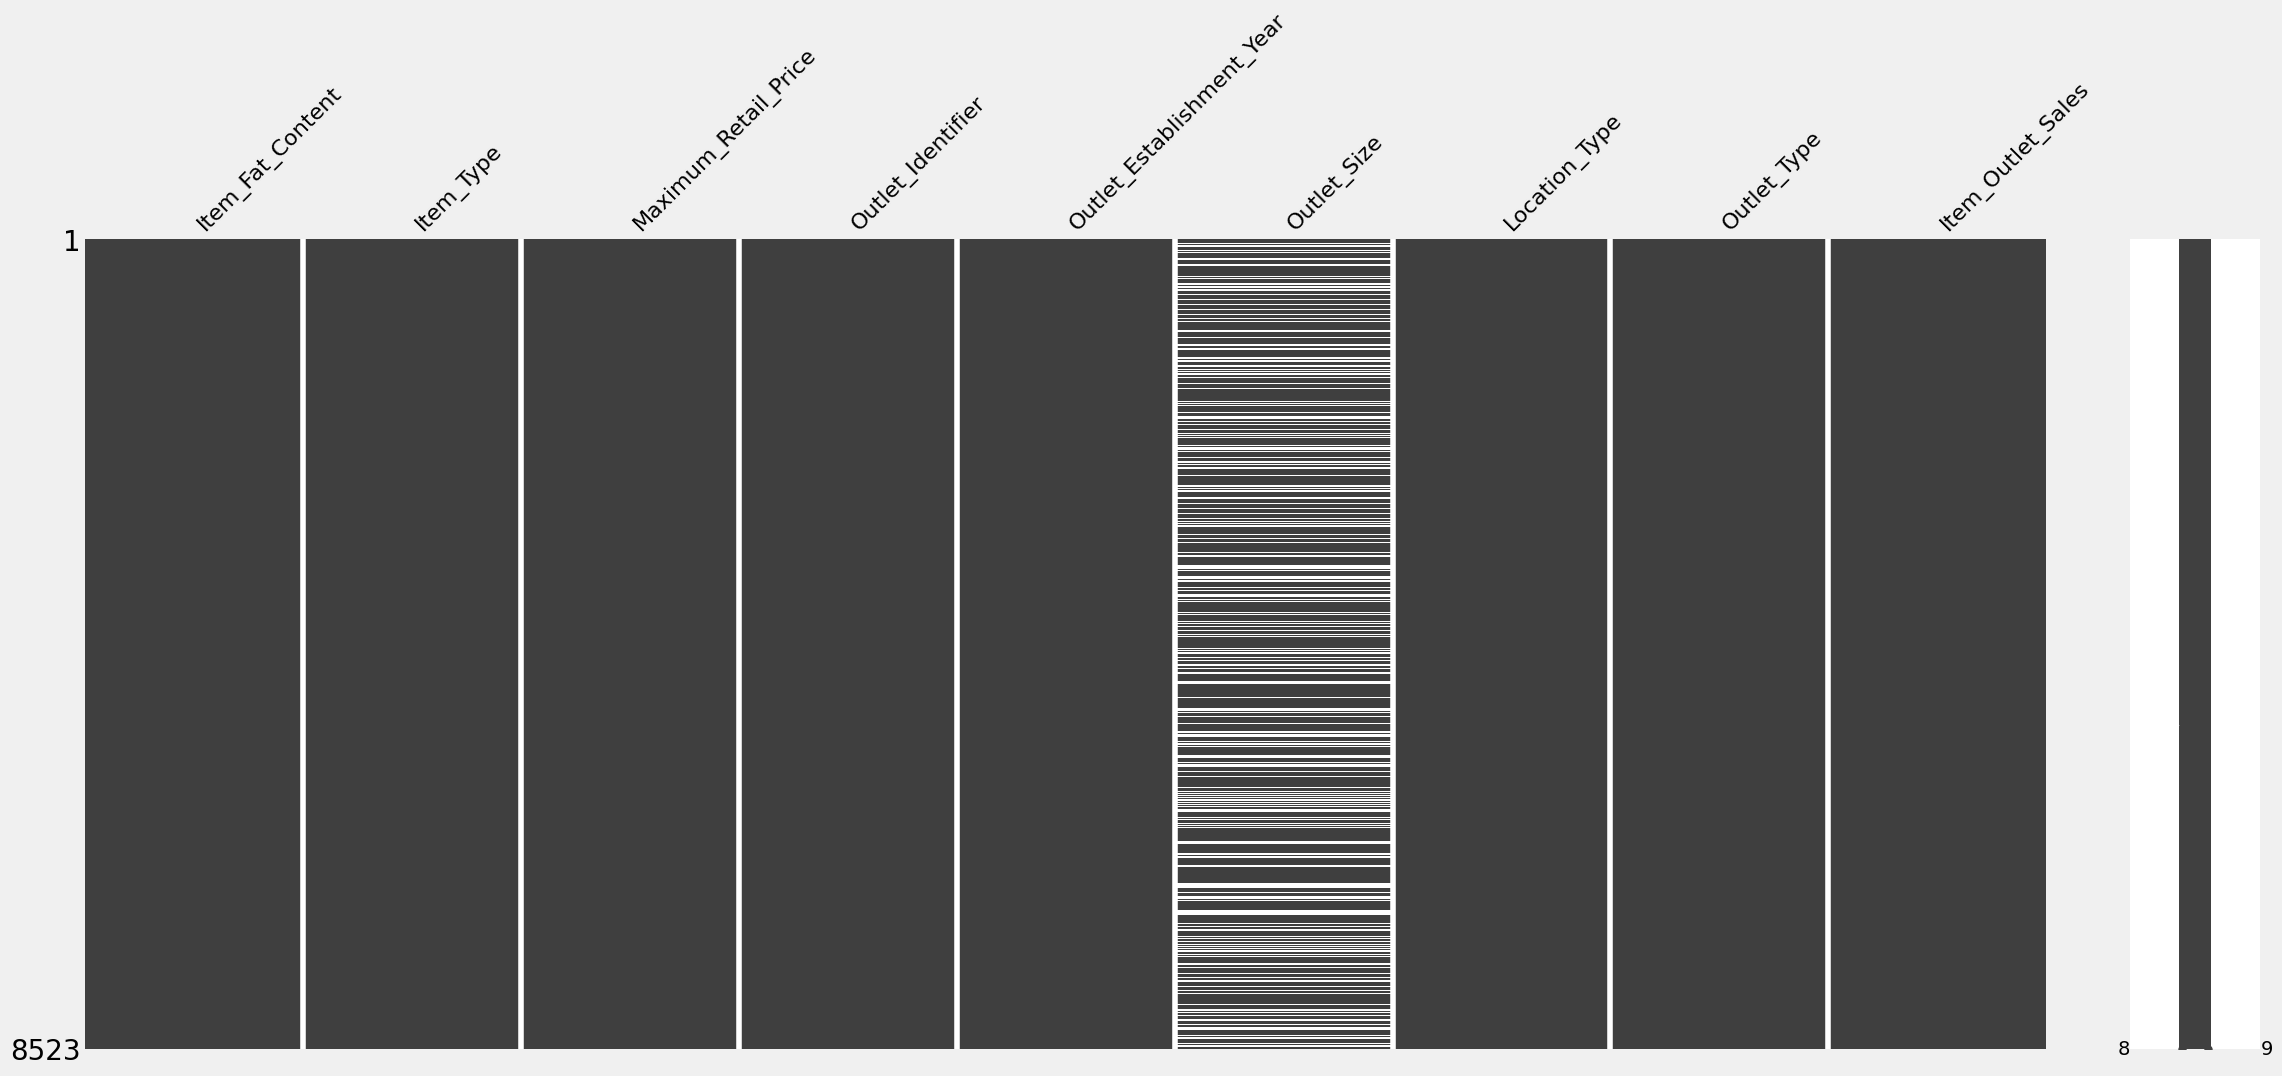

In [ ]:
# We will use missingno to visualize null values in the data set.

msno.matrix(df);

### Data summaries

In [ ]:
# .describe() is used on numerical columns in the DataFrame.
# A DataFrame is shown with the statistical summary of each column.

df.describe(include='number')

,Maximum_Retail_Price,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000
mean,140.992782,1997.831867,2181.288914
std,62.275067,8.371760,1706.499616
min,31.290000,1985.000000,33.290000
25%,93.826500,1987.000000,834.247400
50%,143.012800,1999.000000,1794.331000
75%,185.643700,2004.000000,3101.296400
max,266.888400,2009.000000,13086.964800


In [ ]:
df.describe(exclude='number')

,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Location_Type,Outlet_Type
count,8523,8523,8523,6113,8523,8523
unique,2,10,10,3,3,4
top,Low Fat,Misc. Food,OUT027,Medium,Tier 3,Supermarket Type1
freq,5517,1806,935,2793,3350,5577


## Exploratory Data Analysis

### Histograms showing distributions of:

#### Maximum retail prices of products

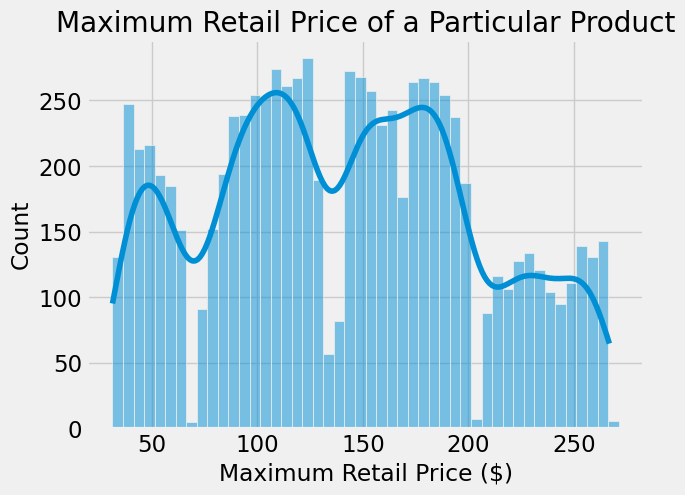

In [ ]:
# A histogram is created to visualize Maximum Retail Price.

ax = sns.histplot(data=df, x='Maximum_Retail_Price', binwidth=5, kde=True)

ax.set(xlabel='Maximum Retail Price ($)', ylabel='Count',
       title='Maximum Retail Price of a Particular Product');

#### Item sales

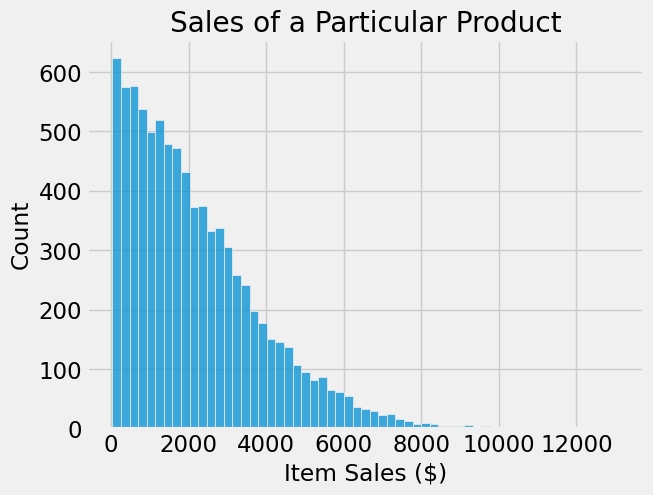

In [ ]:
ax = sns.histplot(data=df, x='Item_Outlet_Sales')

ax.set(xlabel='Item Sales ($)', ylabel='Count',
       title='Sales of a Particular Product');

### Boxplots showing statistical summaries of:

#### Item sales

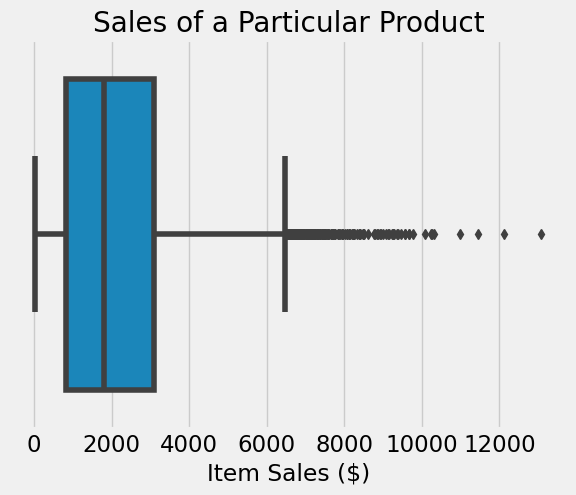

In [ ]:
# A boxplot is created to visualize Item Outlet Sales.

ax = sns.boxplot(data=df, x='Item_Outlet_Sales')

ax.set(xlabel='Item Sales ($)', title='Sales of a Particular Product');

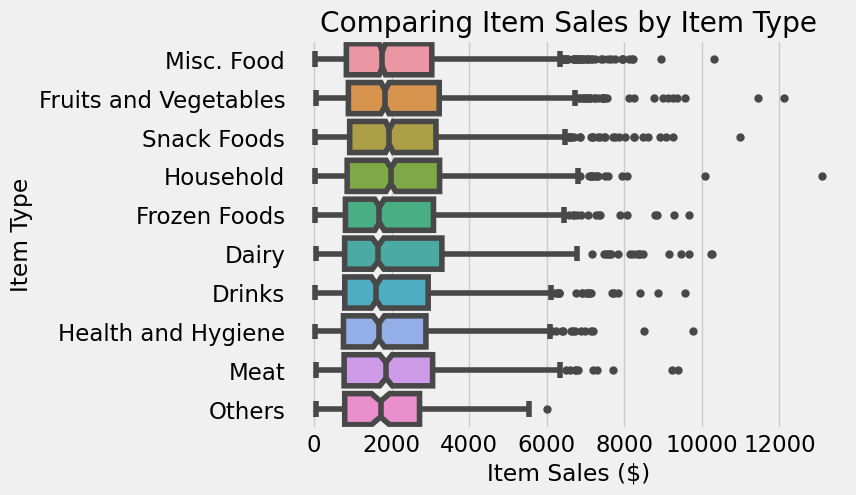

In [ ]:
# A variable is created to sort and store the value counts of 'Item_Types.
# Variables are created for each categorical plot henceforth.
# It stores the value counts of the respective columns to be used as an index.

item_val_count = df['Item_Type'].value_counts()

## https://seaborn.pydata.org/generated/seaborn.boxplot.html
# Referencing the link, arguments are passed within the .boxplot() function:
  # Notch marks at the median are created using notch=True.
  # Outlier markers are changed using a dictionary for flierprops.
# 'order' is set to the index of item_val_count.

ax = sns.boxplot(data=df, y='Item_Type', x='Item_Outlet_Sales',
                 order=item_val_count.index,
                 notch=True, flierprops={'marker': 'o'})

ax.set(ylabel = 'Item Type', xlabel='Item Sales ($)',
       title='Comparing Item Sales by Item Type');

### Bar plots showing the frequency of each value for:

#### Item fat content

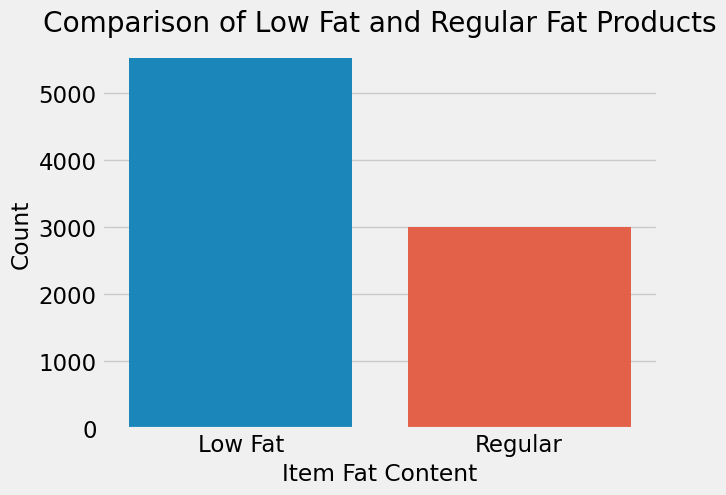

In [ ]:
val_counts = df['Item_Fat_Content'].value_counts()

# The Seaborn .countplot() function is used to create a multivariate bar plot.
# order=val_counts.index sorts the order of bars
# from highest count to lowest on the graph.

ax = sns.countplot(data=df, x='Item_Fat_Content', order=val_counts.index)

ax.set(xlabel='Item Fat Content', ylabel='Count',
       title='Comparison of Low Fat and Regular Fat Products');

#### Item types

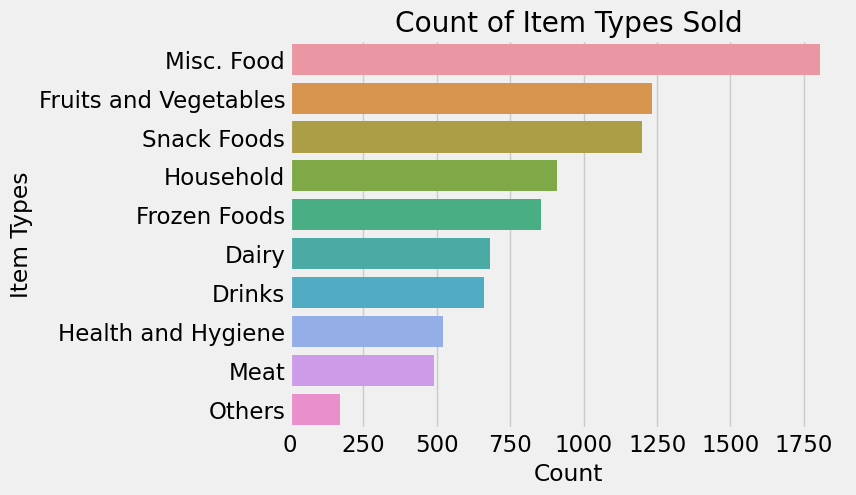

In [ ]:
ax = sns.countplot(data=df, y='Item_Type', order=item_val_count.index)

ax.set(ylabel='Item Types', xlabel='Count', title='Count of Item Types Sold');

#### Outlet sizes

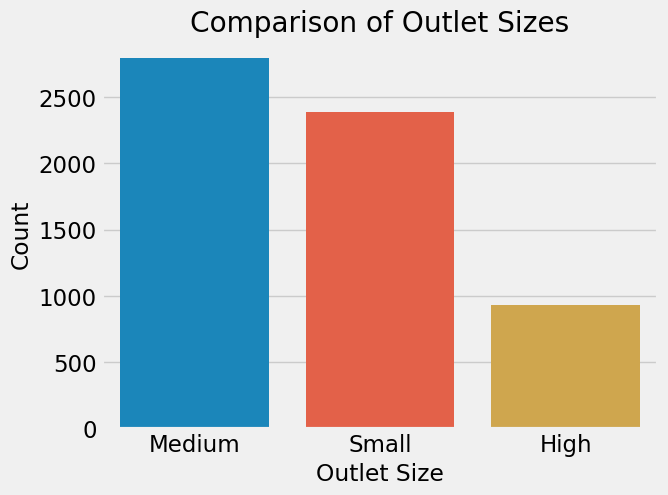

In [ ]:
out_size_val_count = df['Outlet_Size'].value_counts()

ax = sns.countplot(data=df, x='Outlet_Size', order=out_size_val_count.index)

ax.set(xlabel='Outlet Size', ylabel='Count',
       title='Comparison of Outlet Sizes');

#### Outlet location types

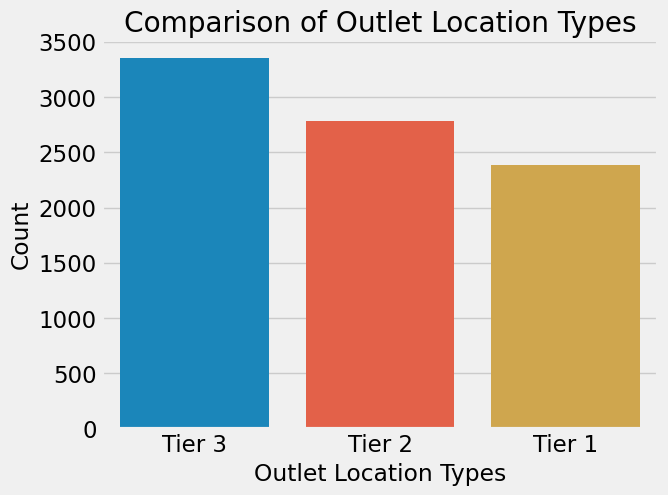

In [ ]:
loc_type_val_count = df['Location_Type'].value_counts()

ax = sns.countplot(data=df, x='Location_Type', order=loc_type_val_count.index)

ax.set(xlabel='Outlet Location Types', ylabel='Count',
       title='Comparison of Outlet Location Types');

#### Outlet types

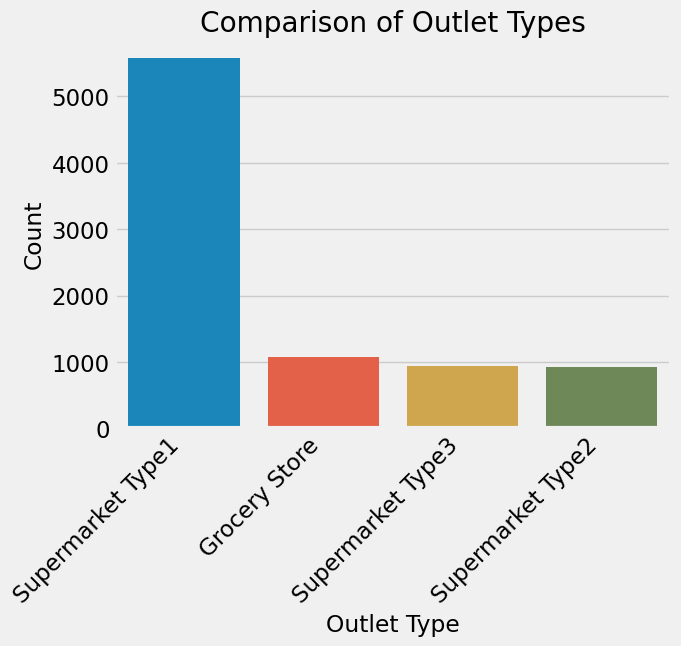

In [ ]:
outlet_type_val_count = df['Outlet_Type'].value_counts()

ax = sns.countplot(data=df, x='Outlet_Type', order=outlet_type_val_count.index)

# The function .set_xticklabels() adjusts the tick labels on the x-axis.
  # .get_xticklabels() gets the x-axis tick labels as a list.
  # rotation=45 rotates the labels by 45 degrees so they do not overlap.
  # ha='right' horizontally aligns the labels to the right.

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set(xlabel='Outlet Type', ylabel='Count',
       title='Comparison of Outlet Types');

### Correlations in the data set

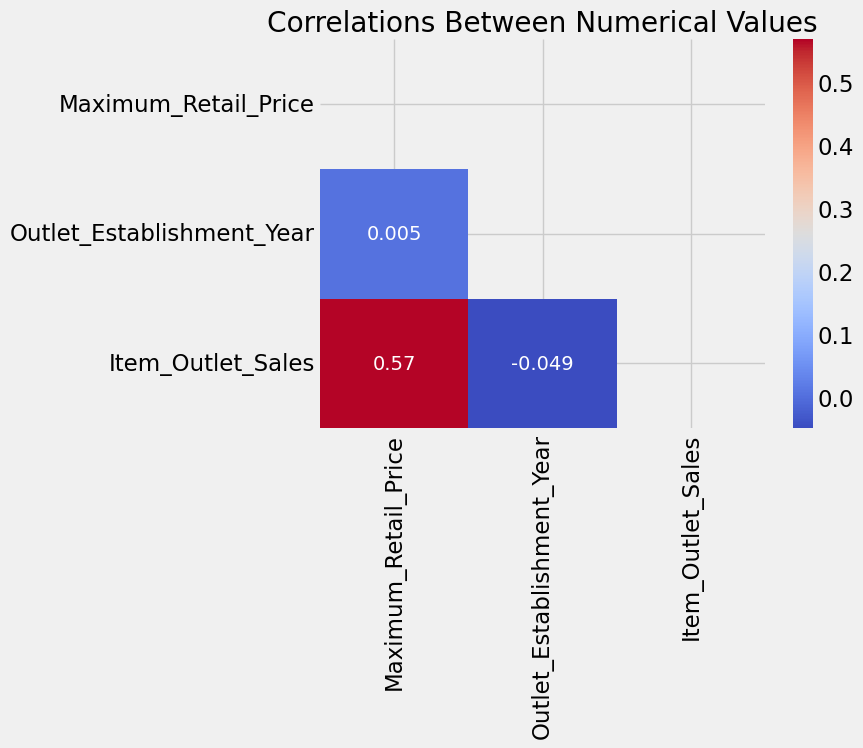

In [ ]:
# A variable is created using the .corr() function.
# The .corr() function returns coefficients for correlations between two values.
# Since we are only comparing numerical values,
# we pass the argument numeric_only=True.
num_corr = df.corr(numeric_only = True)

# A mask is created using the .triu() method
# to cover duplicates, or "ones_like", of num_corr.
pairplot_mask = np.triu(np.ones_like(num_corr))

# The function subplots() is used to create a figure and axes
# in which the correlation map is held.
# This is stored within fig, ax (figure, axes).
fig, ax = plt.subplots()

# The Seaborn function .heatmap() is used to create a map of coefficients
# based on the num_corr data.
  # cmap='coolwarm' adjusts the color scheme.
  # annot=True will label each cell with a coefficient.
  # mask=pairplot_mask creates a mask using the previous variable.

sns.heatmap(num_corr, cmap= 'coolwarm', annot= True, mask=pairplot_mask)

ax.set_title('Correlations Between Numerical Values');

#### Scatter plots showing the correlation between:

##### Maximum retail price and Item sales

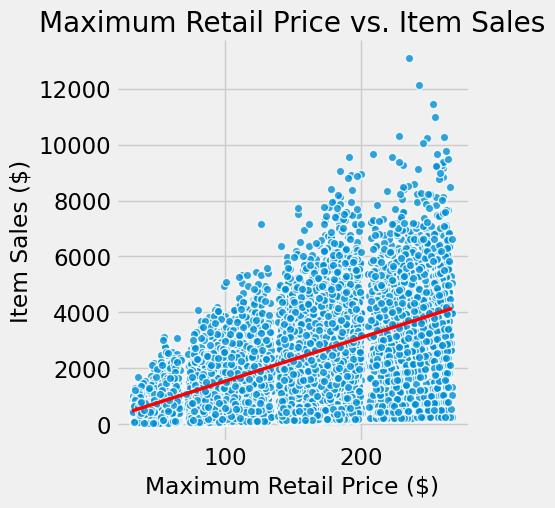

In [ ]:
# The Seaborn method .lmplot() is used to create a scatterplot of the data.
# scatter_kws=scatter_kws creates a white outline around each point on the plot.
# line_kws changes the appearance of the regression fit line via a dictionary.
  # 'color' changes the color.
  # 'lw' adjusts the line weight based on the value given.

ax = sns.lmplot(data=df, x='Maximum_Retail_Price', y='Item_Outlet_Sales',
                scatter_kws=scatter_kws, line_kws={'color':'red', 'lw':2.5})

ax.set(xlabel= 'Maximum Retail Price ($)', ylabel= 'Item Sales ($)',
       title='Maximum Retail Price vs. Item Sales');

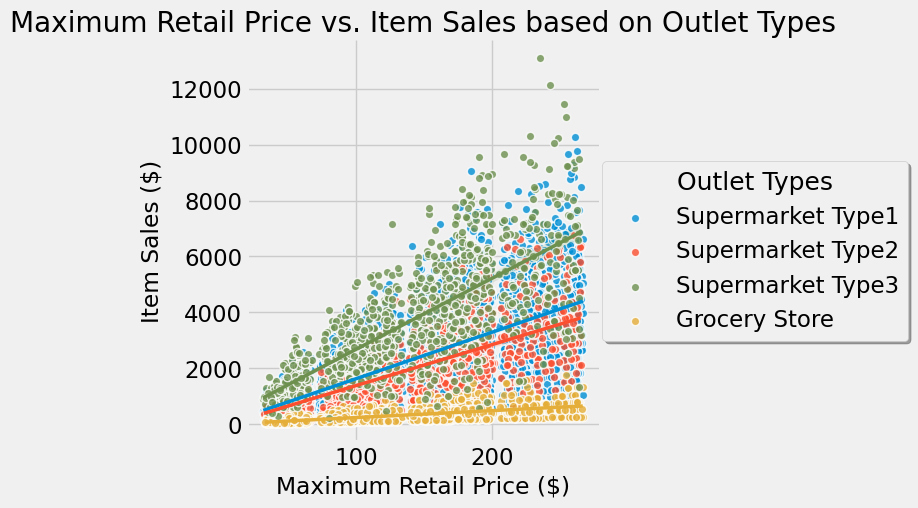

In [ ]:
ax = sns.lmplot(data=df, x='Maximum_Retail_Price', y='Item_Outlet_Sales',
                scatter_kws=scatter_kws, hue='Outlet_Type',
                line_kws={'lw':2.5}, legend=False)

# The legend is removed in order to create a new one.

ax.set(xlabel= 'Maximum Retail Price ($)', ylabel= 'Item Sales ($)',
       title='Maximum Retail Price vs. Item Sales based on Outlet Types')

# The order of the labels in the legend were originally out of order.
# The labels in the legend are reorganized referencing the code linked below:
  # https://www.statology.org/matplotlib-legend-order/

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,3,2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           # The location of the legend is set using coordinates.
           # A shadow is added to the legend.
           # The legend is retitled to remove the underscore.
           loc=(1.01, 0.25), shadow=True, title='Outlet Types')

plt.show();

## Explanatory Data Analysis

### Item_Fat_Content

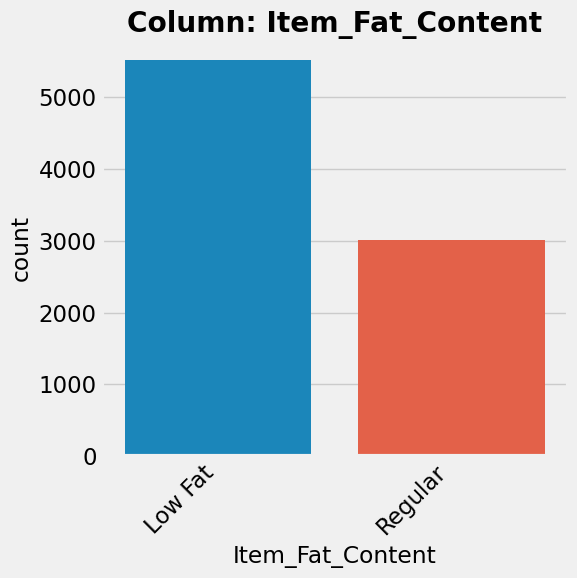

- NaN's Found: 0 (0.0%)
- Low cardinality; 2 unique values.
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [ ]:
viz_categorical(df, x='Item_Fat_Content');

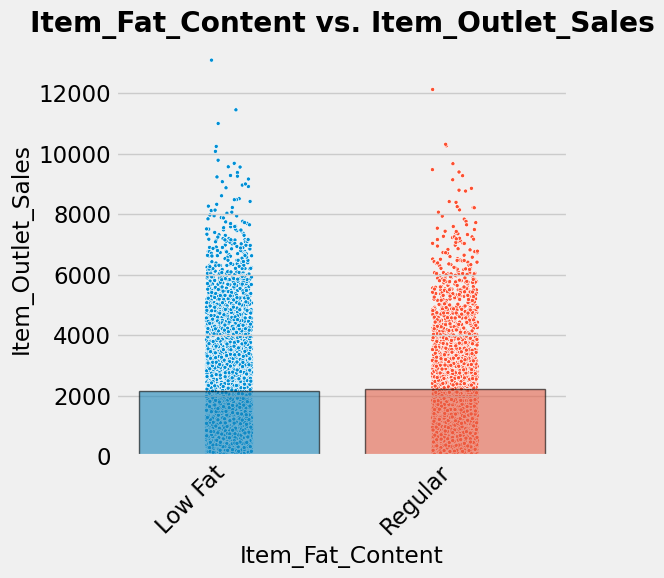

In [ ]:
viz_categorical_vs_target(df, x='Item_Fat_Content', y='Item_Outlet_Sales');

- There is no apparent difference between the impact of low fat and regular fat content products on sales.

### Item_Type

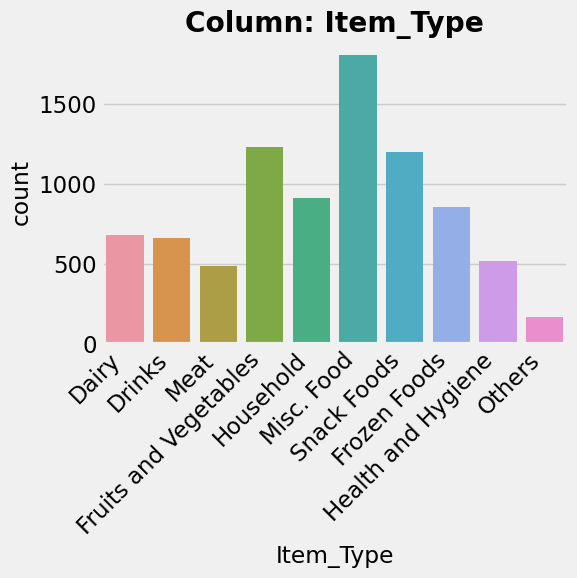

- NaN's Found: 0 (0.0%)
- Low cardinality; 10 unique values.
- Most common value: 'Misc. Food' occurs 1806 times (21.19%)
- Not constant or quasi-constant.


In [ ]:
viz_categorical(df, x='Item_Type');

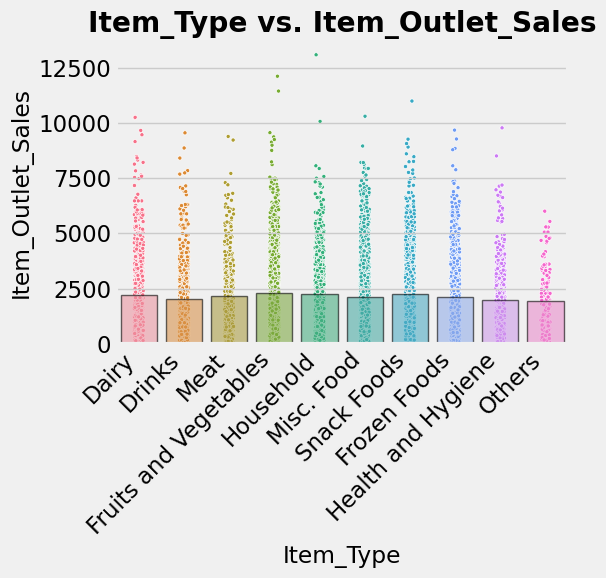

In [ ]:
viz_categorical_vs_target(df, x='Item_Type', y='Item_Outlet_Sales');

- Despite the variety of item types, there is no particular item type that impacts sales more than another.

### Maximum_Retail_Price

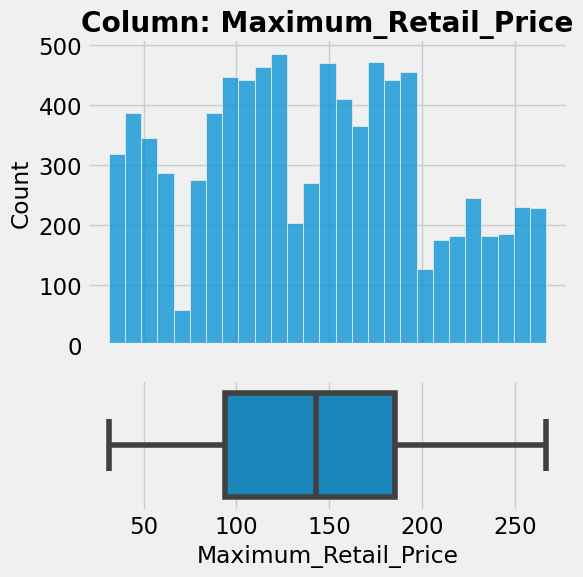

Type of feature: Numerical
- NaN's Found: 0 (0.0%)


In [ ]:
viz_numerical(df, x='Maximum_Retail_Price');

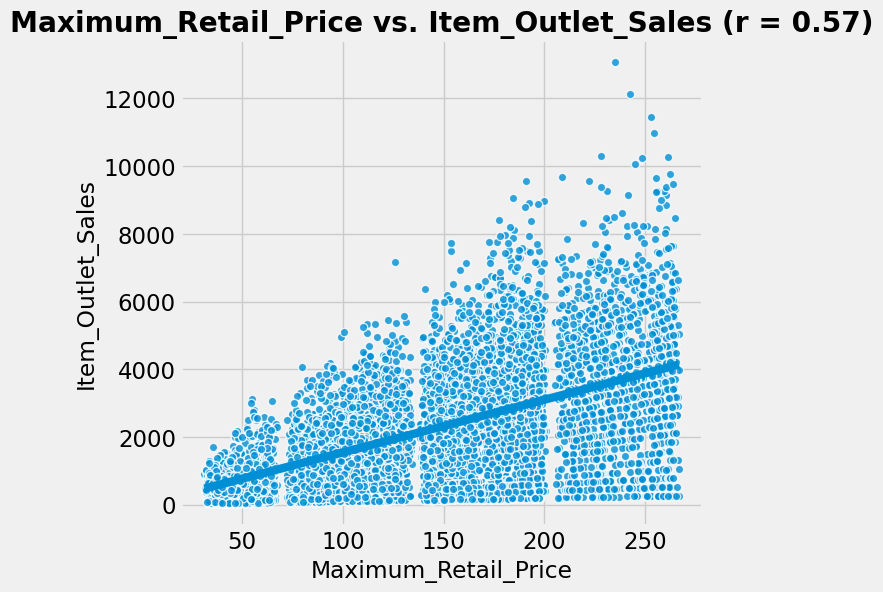

In [ ]:
viz_numeric_vs_target(df, x='Maximum_Retail_Price', y='Item_Outlet_Sales');

- There is a moderate positive correlation between the maximum retail price of an item and its sales.

### Outlet_Identifier

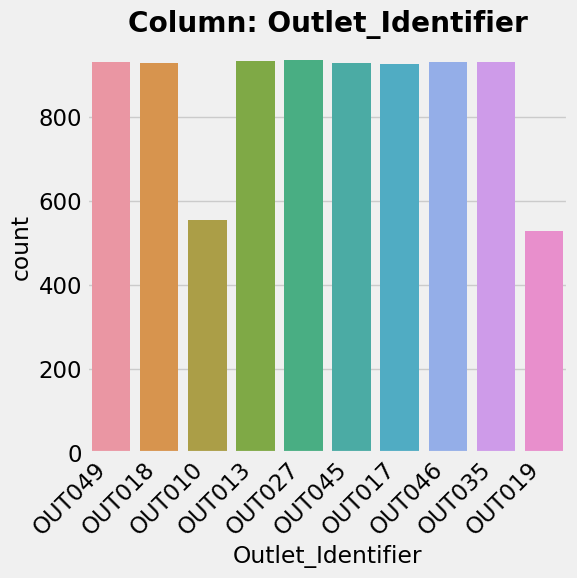

- NaN's Found: 0 (0.0%)
- Low cardinality; 10 unique values.
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


In [ ]:
viz_categorical(df, x='Outlet_Identifier');

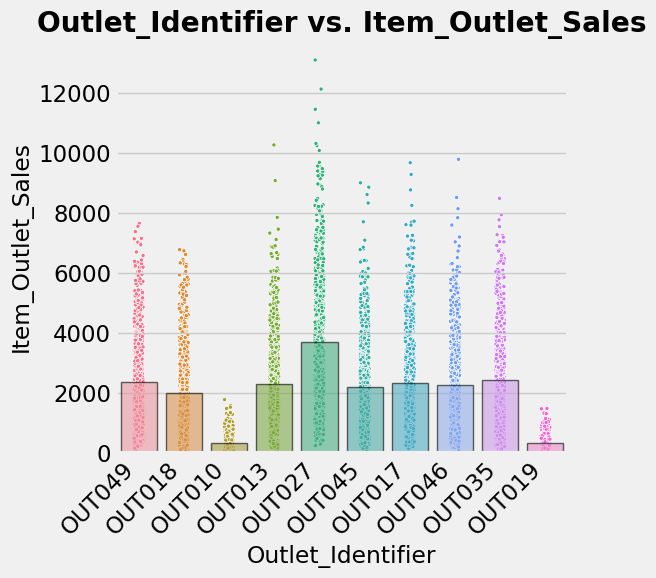

In [ ]:
viz_categorical_vs_target(df, x='Outlet_Identifier', y='Item_Outlet_Sales');

- There is a correlation between specific outlets and their sales. Outlets OUT019 and OUT019 sell fewer products and have lower median sales. Outlet OUT027 has the greatest median sales.

### Outlet_Size

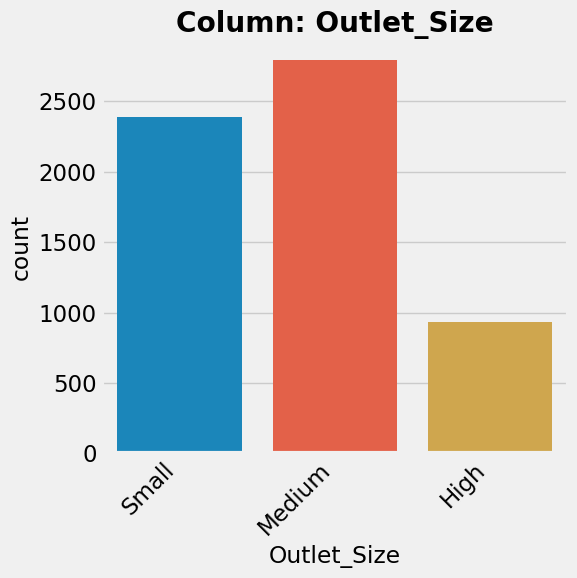

- NaN's Found: 2410 (28.28%)
Null values will be filled with the placeholder, 'MISSING'.
- Low cardinality; 4 unique values.
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


In [ ]:
# Since the data is ordinal, the order is stored in a new variable.
outlet_size_order = ['Small', 'Medium', 'High']

# The order is set to the order variable created earlier.
viz_categorical(df, x='Outlet_Size', order=outlet_size_order);

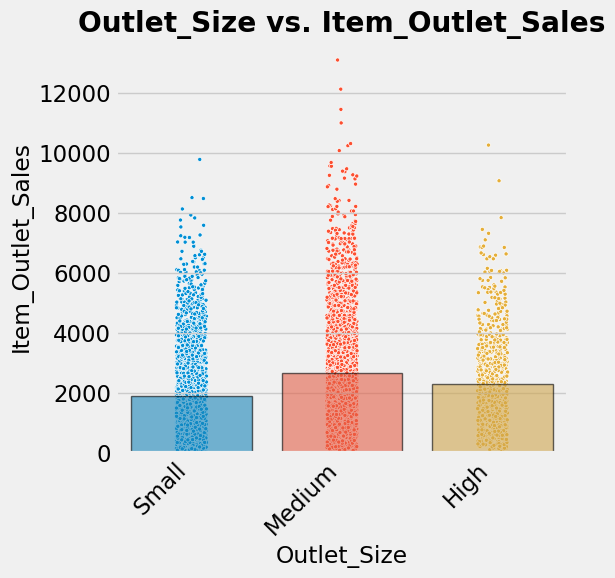

In [ ]:
viz_categorical_vs_target(df, x='Outlet_Size', y='Item_Outlet_Sales',
                          order=outlet_size_order);

- Despite a high difference in count between Small and Medium outlets vs. High outlets, High outlets have similar median outlet sales.

### Location_Type

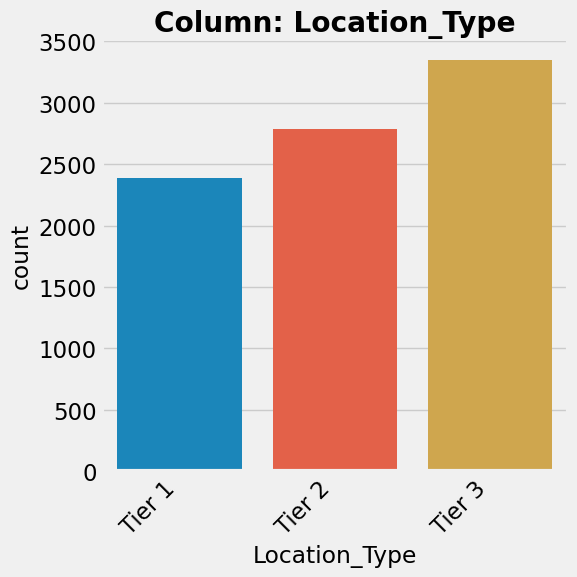

- NaN's Found: 0 (0.0%)
- Low cardinality; 3 unique values.
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


In [ ]:
location_type_order= ['Tier 1', 'Tier 2', 'Tier 3']

viz_categorical(df, x='Location_Type', order=location_type_order);

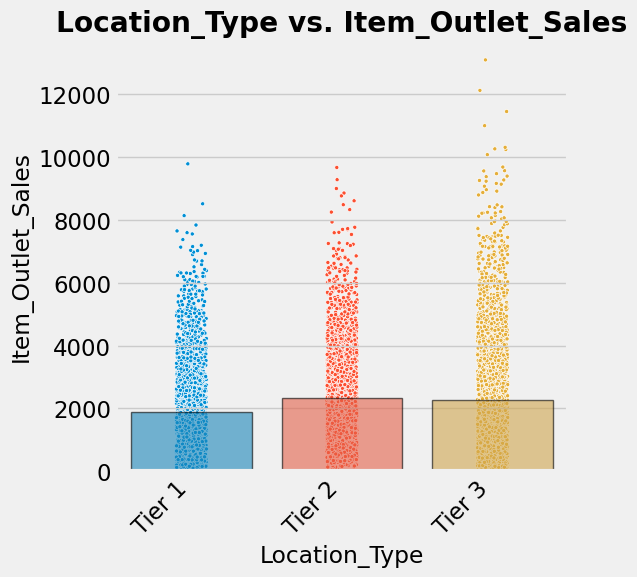

In [ ]:
viz_categorical_vs_target(df, x='Location_Type', y='Item_Outlet_Sales',
                          order=location_type_order);

- There is a higher count of Tier 3 location types, but Tier 2 locaion types have the highest median sales.

### Outlet_Type

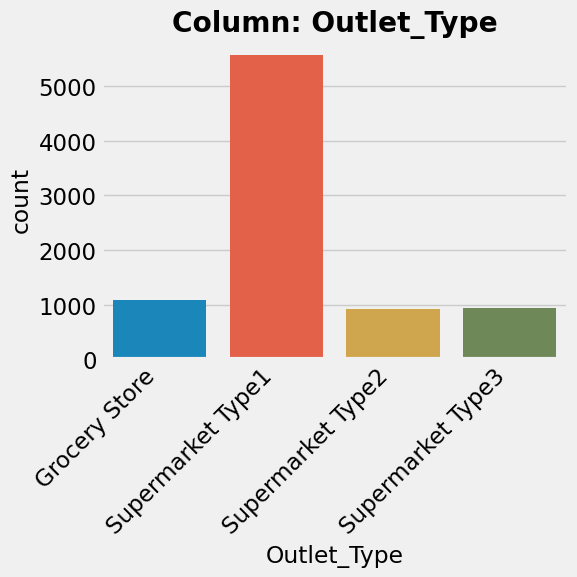

- NaN's Found: 0 (0.0%)
- Low cardinality; 4 unique values.
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


In [ ]:
outlet_type_order = ['Grocery Store', 'Supermarket Type1',
                     'Supermarket Type2', 'Supermarket Type3']

viz_categorical(df, x='Outlet_Type', order=outlet_type_order);

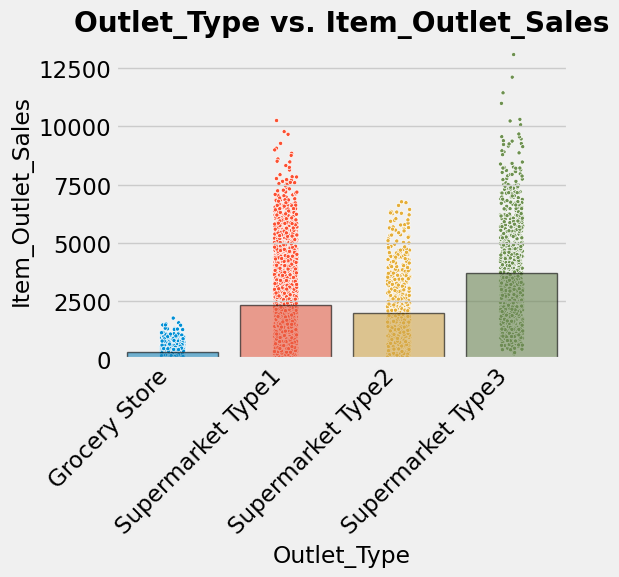

In [ ]:
viz_categorical_vs_target(df, x='Outlet_Type', y='Item_Outlet_Sales',
                          order=outlet_type_order);

- Most outlet types have similar counts except for Supermarket Type1, which has a far higher count. Despite this, Supermarket Type3 reports the highest median sales.
- Grocery stores report the lowest median sales.

## Preparing the Data for Machine Learning

### Splitting the data

In [ ]:
# The target vector is stored in y
y = df['Item_Outlet_Sales'].copy()

# The features matrix is stored in X as a copy
X = df.drop(columns='Item_Outlet_Sales').copy()

# The dataset is split into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Creating pathways for the ColumnTransformer

In [ ]:
# Number-type features are stored
num_cols = X_train.select_dtypes('number').columns

# An instance of StandardScaler is created
num_scaler = StandardScaler()

# A tuple is created for the ColumnTransformer
num_tuple= ('numeric', num_scaler, num_cols)

In [ ]:
# The process is repeated for ordinal-type features

ord_cols = ['Outlet_Size', 'Location_Type', 'Outlet_Type']

# The strategy and fill_value arguments are adjusted
impute_ord = SimpleImputer(strategy='constant', fill_value='NA')

# Lists are created for each ordinal feature
size_order = ['NA', 'Small', 'Medium', 'High']
tier_order = ['Tier 1', 'Tier 2', 'Tier 3']
type_order = ['Grocery Store', 'Supermarket Type1',
              'Supermarket Type2', 'Supermarket Type3']

# Each list is stored in another list
ordinal_category_orders = [size_order, tier_order, type_order]

# An instance of OrdinalEncoder is created using the stored list
# This will transform the values stored into numerical values
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

ord_scaler = StandardScaler()

ord_pipe = make_pipeline(impute_ord, ord_encoder, ord_scaler)

ord_tuple = ('ordinal', ord_pipe, ord_cols)

In [ ]:
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns

# An instance of OneHotEncoder is created
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# A pipeline is not created because it is not needed
# In its place, the instance of OneHotEncoder is passed as an argument
cat_tuple = ('nominal', ohe_encoder, cat_cols)

### Creating the ColumnTransformer

In [ ]:
# An instance of ColumnTransformer uses the tuples created
col_transformer = ColumnTransformer([num_tuple, ord_tuple, cat_tuple],
                                    verbose_feature_names_out=False)

# The ColumnTransformer is fit to the training set
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 Index(['Maximum_Retail_Price', 'Outlet_Establishment_Year'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3'],
                                                                             ['Grocery '
                                                                              'Store',
                                                                              'Supermarket '
                                                                              'Type1',
                                                                              'Supermarket '
                                                                              'Type2',
                                                                              'Supermarket '
                                                                              'Type3']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size', 'Location_Type',
                                  'Outlet_Type']),
                                ('nominal',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier'], dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
# The training and testing sets are transformed
X_train_tf = col_transformer.transform(X_train)
X_test_tf = col_transformer.transform(X_test)

# The new training set is previewed
X_train_tf.head()

,Maximum_Retail_Price,Outlet_Establishment_Year,Outlet_Size,Location_Type,Outlet_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Dairy,Item_Type_Drinks,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Misc. Food,Item_Type_Others,Item_Type_Snack Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
4776,1.828109,1.327849,0.748125,1.084948,0.983572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7510,0.603369,1.327849,0.748125,1.084948,0.983572,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5828,0.244541,0.136187,0.748125,-1.384777,-0.263600,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5327,-0.952591,0.732018,-0.264370,-0.149914,-0.263600,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4810,-0.336460,0.493686,-1.276865,-0.149914,-0.263600,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Credit to the Coding Dojo

def regression_metrics(y_true, y_pred, label='', verbose=True,
                       output_dict=False):

  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)

  if verbose == True:
    header = '-'*60
    print(header, f'Regression Metrics: {label}', header, sep='\n')
    print(f'- MAE = {mae:,.3f}')
    print(f'- MSE = {mse:,.3f}')
    print(f'- RMSE = {rmse:,.3f}')
    print(f'- R^2 = {r_squared:,.3f}')

  if output_dict == True:
    metrics = {'Label':label, 'MAE':mae, 'MSE':mse,
               'RMSE':rmse, 'R^2':r_squared}
    return metrics


def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose=True,
                        output_frame=False):

  y_train_pred = reg.predict(X_train)
  results_train = regression_metrics(y_train, y_train_pred, verbose=verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()

  y_test_pred = reg.predict(X_test)
  results_test = regression_metrics(y_test, y_test_pred, verbose=verbose,
                                    output_dict=output_frame,
                                    label='Test Data')
  if output_frame == True:
    results_df = pd.DataFrame([results_train, results_test])
    results_df = results_df.set_index('Label')
    results_df.index.name=None
    return results_df.round(3)

In [ ]:
# A Linear Regression model is stored as a variable.
lin_reg = LinearRegression()

# The model is fit to the training data.
lin_reg.fit(X_train_tf, y_train)

# Metrics are called using the Linear Regression model.
evaluate_regression(lin_reg, X_train_tf, y_train, X_test_tf, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.535
- MSE = 1,298,857.819
- RMSE = 1,139.674
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 802.281
- MSE = 1,191,218.505
- RMSE = 1,091.430
- R^2 = 0.568


- The Linear Regression model is underfit. Looking at the R^2 values (0.561 & 0.568), there is still room for improvement to better fit the model.

In [ ]:
# A default Random Forest model is stored as a variable.
rf = RandomForestRegressor(random_state=42)

# The Random Forest model is fit to the training data.
rf.fit(X_train_tf, y_train)

# Metrics are called using the Random Forest model.
evaluate_regression(rf, X_train_tf, y_train, X_test_tf, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 305.186
- MSE = 198,159.845
- RMSE = 445.151
- R^2 = 0.933

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 800.351
- MSE = 1,334,529.459
- RMSE = 1,155.218
- R^2 = 0.516


- The model is overfit to the training data. There is a high R^2 value on the training data (0.933), but this value drops drastically on the testing data (0.516).
- Comparing the Random Forest model to the Linear Regression model, the Linear Regression model better performs since the R^2 value is higher on the testing data (0.568 vs. 0.516).

In [ ]:
# The parameters on the random forest model will be adjusted using GridSearchCV.
# A set of parameters is stored.

params = {'max_depth': [None, 2, 5, 10, 20],
          'n_estimators': [50, 100, 200, 300, 400],
          'min_samples_leaf': [3, 4, 5, 6],
          'max_features': ['sqrt', 'log2', None],
          'oob_score': [True, False]}

# GridSearchCV is called using the random forest model and the parameters.
gridsearch = GridSearchCV(rf, params, n_jobs=-1, verbose=1)

# The gridsearch variable is fit to the data.
gridsearch.fit(X_train_tf, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 5, 10, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 200, 300, 400],
                         'oob_score': [True, False]},
             verbose=1)

In [ ]:
# The best parameters are called.
gridsearch.best_params_

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 3,
 'n_estimators': 400,
 'oob_score': True}

In [ ]:
# The best parameters are called and stored in a variable.
best_rf = gridsearch.best_estimator_

# Metrics are called using the best parameters found using GridSearchCV.
evaluate_regression(best_rf, X_train_tf, y_train, X_test_tf, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 756.096
- MSE = 1,155,370.023
- RMSE = 1,074.881
- R^2 = 0.610

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 728.582
- MSE = 1,094,741.409
- RMSE = 1,046.299
- R^2 = 0.603


- This model is better fit to the data than the default Random Forest model. The R^2 score on the testing data improved from 0.516 to 0.603.

**Linear Regression**

  |  | Training Data | Testing Data |
  | ------------- | ------------- | ------------ |
  | MAE | 847.535 | 802.281 |
  | MSE | 1,298,857.819 | 1,191,218.505 |
  | RMSE | 1,139.674 | 1,091.430 |
  | R^2 | 0.561 | 0.568 |

----------

**Default Random Forest**

  |  | Training Data | Testing Data |
  | ------------- | ------------- | ------------ |
  | MAE | 305.186 | 800.351 |
  | MSE | 198,159.845 | 1,334,529.459 |
  | RMSE | 45.151 | 1,155.218 |
  | R^2 | 0.933 | 0.516 |

-----------

**Adjusted Random Forest**

  |  | Training Data | Testing Data |
  | ------------- | ------------- | ------------ |
  | MAE | 756.096 | 728.582 |
  | MSE | 1,155,370.023 | 1,094,741.409 |
  | RMSE | 1,074.881 | 1,046.299 |
  | R^2 | 0.610 | 0.603 |

- R^2, or the coefficient of the determination, is a metric that allows us to see how closely our model can predict the target value based on the given features.
- Based on the 3 models tested, the adjusted Random Forest model has the greatest R^2 score for the testing data and can most accurately predict the target value.
- Looking at the mean absolute error, the model has a tendency to predict Item Outlet Sales with an error of $728.58.
- The Mean Absolute Error is chosen to reflect the model's errors instead of the root mean square error because the grocer focuses on sales of low-cost items (<\$267) and larger errors will not be as impactful.
- Although the adjusted Random Forest model is the best model so far, it is still underfit. This could be due to the lack of relevant data to the target.